In [97]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from cartopy import crs as ccrs
import pandas as pd
#import dask
import netCDF4
import xesmf as xe
from matplotlib.colors import SymLogNorm

In [98]:
with xr.open_dataset(r'C:\Users\wilse\Documents\Final_project\RGL-90magl_UKV_rn_EUROPE_202002.nc') as f:
    rgl_202002 = f.load()

In [99]:
rgl_202002

<xarray.Dataset>
Dimensions:               (time: 696, lon: 391, lat: 293, lev: 1, height: 20)
Coordinates:
  * time                  (time) datetime64[ns] 2020-02-01 ... 2020-02-29T23:...
  * lon                   (lon) float32 -97.9 -97.55 -97.2 ... 38.68 39.03 39.38
  * lat                   (lat) float32 10.73 10.96 11.2 ... 78.59 78.82 79.06
  * lev                   (lev) |S1 b'F'
  * height                (height) float32 500.0 1.5e+03 ... 1.85e+04 1.95e+04
Data variables: (12/16)
    fp                    (lat, lon, time) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    temperature           (time) float32 9.252 9.127 9.183 ... 5.117 3.913 4.2
    pressure              (time) float32 974.9 974.2 974.1 ... 957.5 958.2 957.8
    wind_speed            (time) float32 11.52 12.25 10.49 ... 14.96 12.22 13.96
    wind_direction        (time) float32 227.7 231.1 229.2 ... 243.5 219.7 225.8
    PBLH                  (time) float32 402.1 231.0 568.3 ... 355.0 716.5
    ...                    ...
    particle_locations_s  (height, lon, time) float32 0.0 0.0 0.0 ... 0.0 0.0
    particle_locations_w  (height, lat, time) float32 0.0 0.0 0.0 ... 0.0 0.0
    mean_age_particles_n  (height, lon, time) float32 566.9 0.0 ... 0.0 0.0
    mean_age_particles_e  (height, lat, time) float32 0.0 0.0 0.0 ... 0.0 0.0
    mean_age_particles_s  (height, lon, time) float32 0.0 0.0 0.0 ... 0.0 0.0
    mean_age_particles_w  (height, lat, time) float32 0.0 0.0 0.0 ... 0.0 0.0
Attributes: (12/14)
    fp_output_units:          ppm s
    fp_output:                Mixing Ratio
    species:                  Rn
    species_lifetime_hrs:     132.3768
    model:                    NAME
    met_model:                UKV
    ...                       ...
    domain:                   EUROPE
    site:                     RGL
    inlet_height:             90magl
    ACRG_repository_version:  v0.2.0-22-gca6dc68
    author:                   ag12733
    created:                  2021-04-30 10:18:10.035271

In [100]:
with xr.open_dataset(r'C:\Users\wilse\Documents\Final_project\traceRadon_rnflux_GLDAS-Noah_day_2022_v0.6.nc') as f:
    rn_flux_gldas = f.load()

In [101]:
rn_flux_gldas

<xarray.Dataset>
Dimensions:  (time: 365, lat: 780, lon: 860)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31
  * lon      (lon) float32 -10.98 -10.93 -10.88 -10.82 ... 31.88 31.92 31.98
  * lat      (lat) float32 33.03 33.08 33.12 33.17 ... 71.82 71.88 71.93 71.97
Data variables:
    rn_flux  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/17)
    title:                      traceRadon radon flux map for Europe (based o...
    comment:                    not yet fully validated results
    creator:                    Ute Karstens, ICOS ERIC - Carbon Portal,  orc...
    institution:                ICOS ERIC - Carbon Portal, Physical Geography...
    project:                    19ENV01 traceRadon, EMPIR programme
    contact:                    Ute Karstens, ICOS ERIC - Carbon Portal, ute....
    ...                         ...
    source:                     Process-based radon flux model (Karstens et a...
    crs:                        spherical earth with radius of 6367.47 km
    geospatial_lat_resolution:  0.05 degree
    geospatial_lon_resolution:  0.05 degree
    frequency:                  day
    summary:                    Daily radon flux map based on soil uranium co...

In [102]:
print(rn_flux_gldas.dims)

Frozen({'time': 365, 'lat': 780, 'lon': 860})


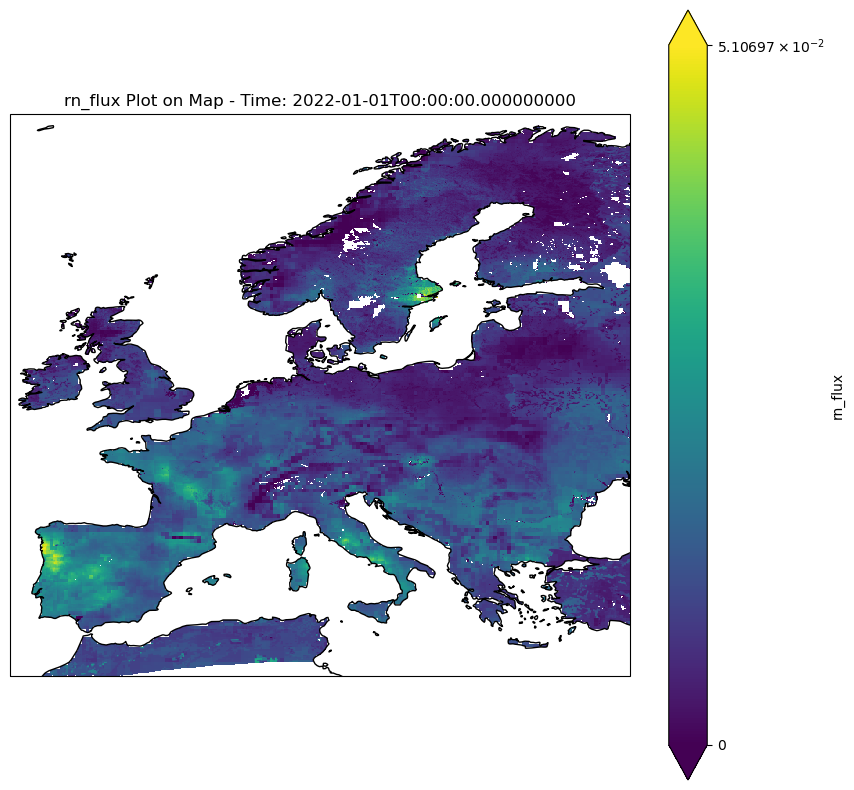

In [103]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Select a specific time (adjust the index as needed)
time_index = 0
rn_flux_gldas_slice = rn_flux_gldas['rn_flux'].isel(time=time_index)

# Determine min and max values, ignoring NaN
vmin = np.nanmin(rn_flux_gldas_slice)
vmax = np.nanmax(rn_flux_gldas_slice)

# Create SymLogNorm with custom options
norm = SymLogNorm(vmin=vmin, vmax=vmax, linthresh=1, linscale=1)

# Plot the data using pcolormesh
im = ax.pcolormesh(rn_flux_gldas_slice['lon'], rn_flux_gldas_slice['lat'], rn_flux_gldas_slice, transform=ccrs.PlateCarree(), cmap='viridis', norm=norm, shading='auto')

# Add colorbar with extend='both' to include arrows for over and under
cbar = plt.colorbar(im, ax=ax, label='rn_flux', extend='both')

plt.title(f'rn_flux Plot on Map - Time: {rn_flux_gldas_slice["time"].values}')
plt.show()

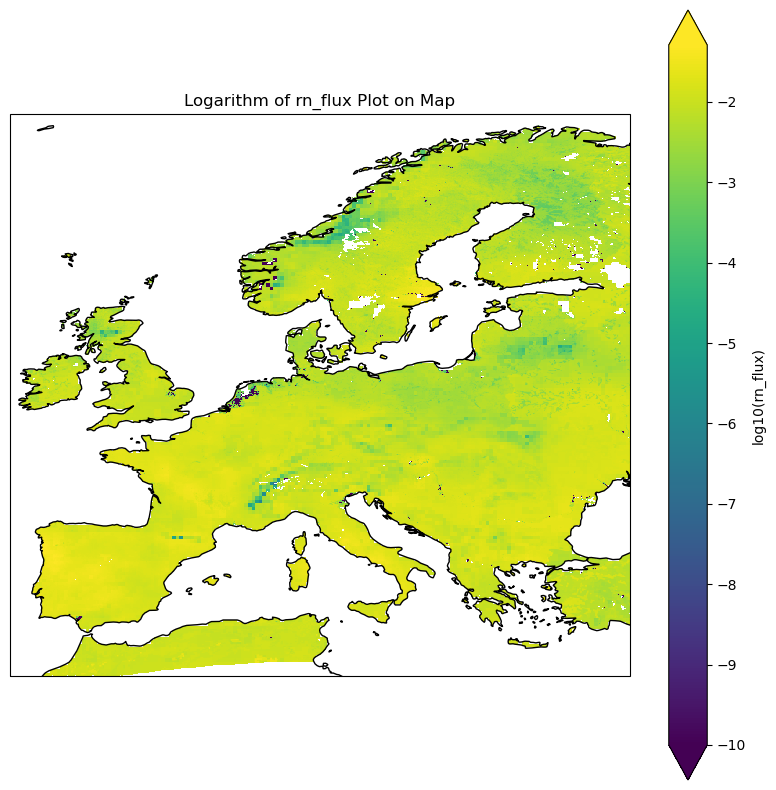

In [104]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

# Add a small constant to avoid taking the logarithm of zero or negative values
rn_flux_log = np.log10(rn_flux_gldas['rn_flux'] + 1e-10)

# Plot the logarithm (base 10) of the radon flux over time using pcolormesh
im = ax.pcolormesh(
    rn_flux_gldas['lon'],
    rn_flux_gldas['lat'],
    rn_flux_log.isel(time=0),  # Adjust the time index as needed
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    shading='auto'
)

# Add colorbar with extend='both' to include arrows for over and under
cbar = plt.colorbar(im, ax=ax, label='log10(rn_flux)', extend='both')

plt.title('Logarithm of rn_flux Plot on Map')
plt.show()

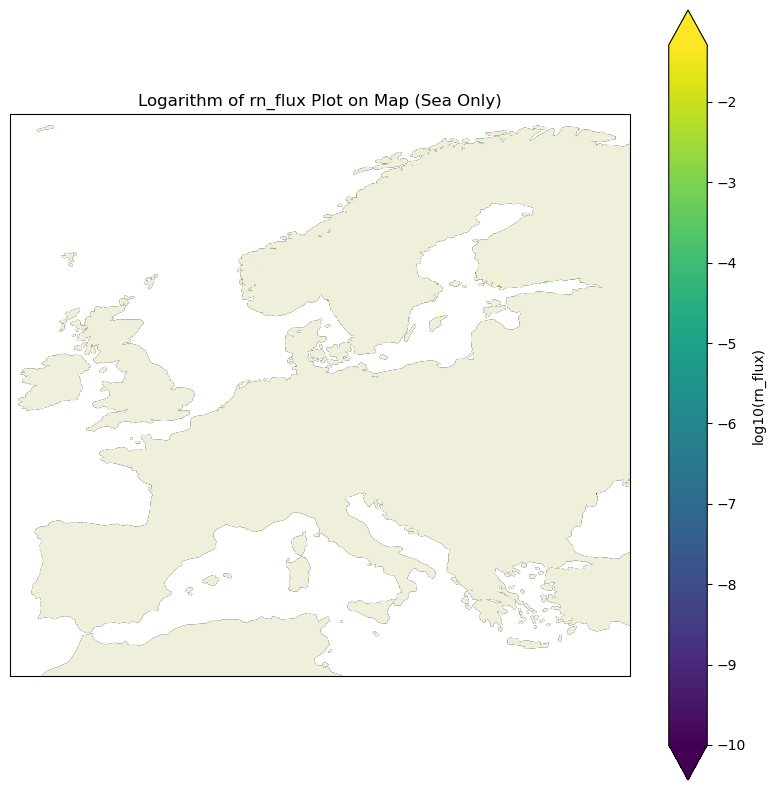

In [105]:
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature

# Add a small constant to avoid taking the logarithm of zero or negative values
rn_flux_log = np.log10(rn_flux_gldas['rn_flux'] + 1e-10)

# Create a land-sea mask using NaturalEarthFeature
land_feature = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    edgecolor='face',
    facecolor=cfeature.COLORS['land']
)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

# Plot the logarithm (base 10) of the radon flux over time using pcolormesh
im = ax.pcolormesh(
    rn_flux_gldas['lon'],
    rn_flux_gldas['lat'],
    rn_flux_log.isel(time=0),
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    shading='auto'
)

# Mask out the land areas
ax.add_feature(land_feature, zorder=2)

# Add colorbar with extend='both' to include arrows for over and under
cbar = plt.colorbar(im, ax=ax, label='log10(rn_flux)', extend='both')

plt.title('Logarithm of rn_flux Plot on Map (Sea Only)')
plt.show()

In [106]:
# So is there no radon flux over the sea? 
# Radon does come from the soil so does its lifespan in the atmosphere mean that it doesnt flux alonf the sea?
# But when plotting the footprint it went across the sea?
# Code must be wrong

In [107]:
print(transposed_rn_flux.sizes['lat'])
print(rgl_202002.sizes['lat'])

780
293


In [108]:
# So the number of latitudes dont line up so I have 3 options to reindex 
# 1 - interpolation 
# 2 - subset the dataset
# 3 - adjust data directly 

# Probably dont want to interpolatre due to the nature of the data 
# Going to subset the data as it aligns lats and longs without interpolation and 
# doesnt fill in missing values 

In [ ]:
# Assuming 'transposed_rn_flux' and 'rgl_202002' are your DataArrays
# Ensure that the coordinates are in ascending order
transposed_rn_flux = transposed_rn_flux.sortby(['lat', 'lon'])
rgl_202002 = rgl_202002.sortby(['lat', 'lon'])

# Extract latitudes and longitudes from one of the datasets
latitudes = transposed_rn_flux['lat'].values
longitudes = transposed_rn_flux['lon'].values

# Ensure that the coordinates are in ascending order
latitudes_rgl = rgl_202002['lat'].values
longitudes_rgl = rgl_202002['lon'].values

# Find common latitudes and longitudes
common_latitudes = np.intersect1d(latitudes, latitudes_rgl)
common_longitudes = np.intersect1d(longitudes, longitudes_rgl)

# Check if common_latitudes and common_longitudes are not empty
if len(common_latitudes) > 0 and len(common_longitudes) > 0:
    # Subset 'rgl_202002' to match the common latitudes and longitudes
    subset_rgl_202002 = rgl_202002.sel(lat=common_latitudes, lon=common_longitudes)

    # Reindex along the time dimension to align with 'subset_rgl_202002.fp'
    reindexed_rn_flux = transposed_rn_flux.reindex_like(subset_rgl_202002, method="nearest")

    # Continue with your calculations
    rn_model = (reindexed_rn_flux * subset_rgl_202002.fp).sum(dim=["lat", "lon"])
else:
    print("Common latitudes or longitudes are empty. Check your data and coordinate values.")

Common latitudes or longitudes are empty. Check your data and coordinate values.


In [ ]:
# Assuming 'transposed_rn_flux' and 'rgl_202002' are your DataArrays
# Ensure that the coordinates are in ascending order
transposed_rn_flux = transposed_rn_flux.sortby(['lat', 'lon'])
rgl_202002 = rgl_202002.sortby(['lat', 'lon'])

# Round the coordinate values to a reasonable precision (adjust decimals as needed)
precision = 4
transposed_rn_flux['lat'] = np.round(transposed_rn_flux['lat'], decimals=precision)
transposed_rn_flux['lon'] = np.round(transposed_rn_flux['lon'], decimals=precision)

rgl_202002['lat'] = np.round(rgl_202002['lat'], decimals=precision)
rgl_202002['lon'] = np.round(rgl_202002['lon'], decimals=precision)

# Extract latitudes and longitudes from one of the datasets
latitudes = transposed_rn_flux['lat'].values
longitudes = transposed_rn_flux['lon'].values

# Ensure that the coordinates are in ascending order
latitudes_rgl = rgl_202002['lat'].values
longitudes_rgl = rgl_202002['lon'].values

# Print the latitudes and longitudes for debugging
print("latitudes:", latitudes)
print("longitudes:", longitudes)
print("latitudes_rgl:", latitudes_rgl)
print("longitudes_rgl:", longitudes_rgl)

# Find common latitudes and longitudes
common_latitudes = np.intersect1d(latitudes, latitudes_rgl)
common_longitudes = np.intersect1d(longitudes, longitudes_rgl)

# Print the common latitudes and longitudes for debugging
print("common_latitudes:", common_latitudes)
print("common_longitudes:", common_longitudes)

# Check if common_latitudes and common_longitudes are not empty
if len(common_latitudes) > 0 and len(common_longitudes) > 0:
    # Subset 'rgl_202002' to match the common latitudes and longitudes
    subset_rgl_202002 = rgl_202002.sel(lat=common_latitudes, lon=common_longitudes)

    # Reindex along the time dimension to align with 'subset_rgl_202002.fp'
    reindexed_rn_flux = transposed_rn_flux.reindex_like(subset_rgl_202002, method="nearest")

    # Continue with your calculations
    rn_model = (reindexed_rn_flux * subset_rgl_202002.fp).sum(dim=["lat", "lon"])
else:
    print("Common latitudes or longitudes are empty. Check your data and coordinate values.")

latitudes: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243

In [ ]:
# Doesnt look like there are any common lats to multply the data together 

In [ ]:
with xr.open_dataset(r'C:\Users\wilse\Documents\Final_project\traceRadon_rnflux_GLDAS-Noah_day_2022_v0.6.nc') as f:
    noah_day = f.load()

# Convert Unix epoch timestamps to datetime objects
timestamps = noah_day['time'].values
noah_day['time'] = pd.to_datetime(timestamps, unit='s')

# Load an example NAME grid from a footprint file
with xr.open_dataset(r'C:\Users\wilse\Documents\Final_project\RGL-90magl_UKV_rn_EUROPE_202002.nc') as f:
    ds_fp_rn = f.load()

# Define the new grid
ds_out = xr.Dataset({'lat': (['lat'], np.linspace(33, 72, 293)),
                     'lon': (['lon'], np.linspace(-11, 32, 391))})

# Perform regridding using linear interpolation
ds_flux_rn_regrid = noah_day.interp(coords={'lat': ds_out['lat'], 'lon': ds_out['lon']}, method='linear')

# Replace NaNs with zeros
ds_flux_rn_regrid = ds_flux_rn_regrid.fillna(0)

In [ ]:
# ERA5 data 2006 - 2022 (find link to data when youi have the chance)

with xr.open_dataset(r'C:\Users\wilse\Documents\Final_project\traceRadon_rnflux_ERA5-Land_month_2006-2022_v0.6.nc') as f:
    era5 = f.load()

# Convert Unix epoch timestamps to datetime objects
timestamps = era5['time'].values
era5['time'] = pd.to_datetime(timestamps, unit='s')

# Load an example NAME grid from a footprint file
with xr.open_dataset(r'C:\Users\wilse\Documents\Final_project\RGL-90magl_UKV_rn_EUROPE_202002.nc') as f:
    ds_fp_rn = f.load()

# Define the new grid
ds_out1 = xr.Dataset({'lat': (['lat'], np.linspace(33, 72, 293)),
                     'lon': (['lon'], np.linspace(-11, 32, 391))})

# Perform regridding using linear interpolation
ds_flux_rn_regrid1 = era5.interp(coords={'lat': ds_out1['lat'], 'lon': ds_out1['lon']}, method='linear')

# Replace NaNs with zeros
ds_flux_rn_regrid1 = ds_flux_rn_regrid1.fillna(0)

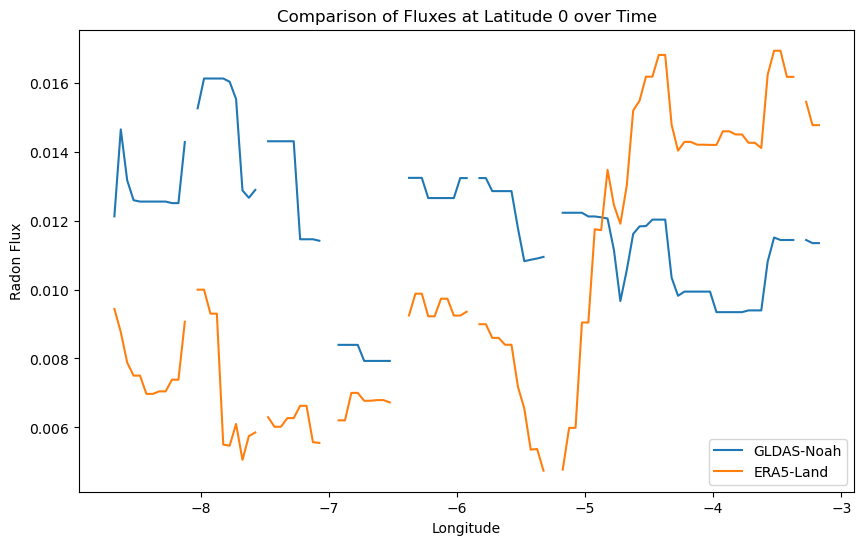

In [ ]:
# Load the GLDAS and ERA5 datasets
with xr.open_dataset(r'C:\Users\wilse\Documents\Final_project\traceRadon_rnflux_GLDAS-Noah_day_2022_v0.6.nc') as f:
    noah_day = f.load()

with xr.open_dataset(r'C:\Users\wilse\Documents\Final_project\traceRadon_rnflux_ERA5-Land_month_2006-2022_v0.6.nc') as f:
    era5 = f.load()

# Convert Unix epoch timestamps to datetime objects
timestamps_noah = noah_day['time'].values
noah_day['time'] = pd.to_datetime(timestamps_noah, unit='s')

timestamps_era5 = era5['time'].values
era5['time'] = pd.to_datetime(timestamps_era5, unit='s')

# Load an example NAME grid from a footprint file
with xr.open_dataset(r'C:\Users\wilse\Documents\Final_project\RGL-90magl_UKV_rn_EUROPE_202002.nc') as f:
    ds_fp_rn = f.load()

# Plot the resulting fluxes on the same graph
plt.figure(figsize=(10, 6))
plt.plot(noah_day['lon'], noah_day['rn_flux'].isel(time=0, lat=0), label='GLDAS-Noah')
plt.plot(era5['lon'], era5['rn_flux'].isel(time=0, lat=0), label='ERA5-Land')
plt.title('Comparison of Fluxes at Latitude 0 over Time')
plt.xlabel('Longitude')
plt.ylabel('Radon Flux')
plt.legend()
plt.show()

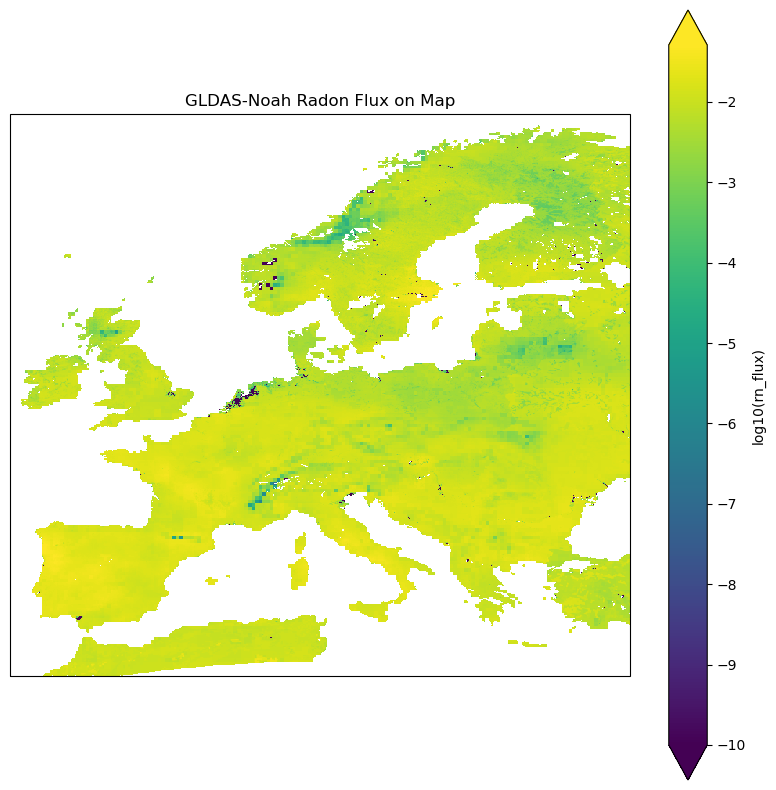

In [ ]:
# Load the GLDAS dataset
with xr.open_dataset(r'C:\Users\wilse\Documents\Final_project\traceRadon_rnflux_GLDAS-Noah_day_2022_v0.6.nc') as f:
    noah_day = f.load()

# Convert Unix epoch timestamps to datetime objects
timestamps_noah = noah_day['time'].values
noah_day['time'] = pd.to_datetime(timestamps_noah, unit='s')

# Create a land-sea mask using NaturalEarthFeature
land_feature = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    edgecolor='face',
    facecolor=cfeature.COLORS['land']
)

# Plot the fluxes on a map
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the logarithm (base 10) of the radon flux over time using pcolormesh
im = ax.pcolormesh(
    noah_day['lon'],
    noah_day['lat'],
    np.log10(noah_day['rn_flux'].isel(time=0) + 1e-10),
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    shading='auto'
)

# Add colorbar with extend='both' to include arrows for over and under
cbar = plt.colorbar(im, ax=ax, label='log10(rn_flux)', extend='both')
plt.title('GLDAS-Noah Radon Flux on Map')

plt.show()

In [ ]:
# removed the confinement of the coastlines but still only on the land. 
# So are the fluxes only on land??
# Happy with this as fluxes are suppose to be on land. YAYYYYY


Now want to calculate the mole fraction via combining the footprint and the fluxes

In [135]:
# Identify the time coordinate in rn_flux_gldas
time_coord = rn_flux_gldas['time']

# Use reindex to align the time resolution of rn_flux_gldas with rn_flux
rn_flux_gldas_reindexed = rn_flux_gldas.reindex(time=rn_flux['time'], method='nearest')

# Now, can perform further operations with the aligned datasets
# can add the flux and time dimension to rn_flux_gldas_reindexed
rn_flux_aligned = rn_flux_gldas_reindexed.assign({"rn_flux": (("time", "lat", "lon"), rn_flux.values)})

# If want to fill NaNs with zeros after reindexing
rn_flux_aligned = rn_flux_aligned.fillna(0)

# Now, rn_flux_aligned should have the desired time resolution aligned with rn_flux

In [183]:
import gc


# Specify a smaller subsampling factor
subsampling_factor = 8  # Adjust this based on your memory constraints

# Subsample latitudes and longitudes
subsampled_latitudes = rn_flux_gldas.lat[::subsampling_factor].values
subsampled_longitudes = rn_flux_gldas.lon[::subsampling_factor].values

# Subsample the flux data
subsampled_flux_data = rn_flux_gldas.rn_flux.values[:, ::subsampling_factor, ::subsampling_factor]

# Create a new xarray dataset with further subsampled data
rn_flux_gldas_subsampled = xr.Dataset(
    {
        "rn_flux": (["time", "lat", "lon"], subsampled_flux_data),
    },
    coords={"time": rn_flux_gldas.time.values, "lat": subsampled_latitudes, "lon": subsampled_longitudes},
)

print(rn_flux_gldas_subsampled)

# Clear variables and perform garbage collection to free up memory
del subsampled_flux_data
gc.collect()

# Use reindex to align the time resolution of rn_flux_gldas_subsampled with rgl_202002
rn_flux_gldas_reindexed = rn_flux_gldas_subsampled.reindex(time=rgl_202002['time'], method='nearest')

# Initialize an empty list to store the aligned flux arrays
flux_aligned_list = []

# Chunk size for aligning the datasets
chunk_size = 50

# Initialize an empty list to store the aligned flux arrays
flux_aligned_list = []

# Iterate over chunks of time steps and align the flux
for t in range(0, rn_flux_gldas_reindexed.dims['time'], chunk_size):
    chunk_end = min(t + chunk_size, rn_flux_gldas_reindexed.dims['time'])

    # Create a temporary xarray DataArray for the current chunk
    temp_da = xr.DataArray(
        rn_flux_gldas_reindexed.rn_flux.isel(time=slice(t, chunk_end)).values,
        coords={
            "time": rn_flux_gldas_reindexed.time.isel(time=slice(t, chunk_end)).values,
            "lat": rn_flux_gldas_reindexed.lat.values,
            "lon": rn_flux_gldas_reindexed.lon.values,
        },
        dims=["time", "lat", "lon"],  # Adjusted dimensions
    )

    # Use xarray's align function to align the dimensions
    temp_da_aligned, _ = xr.align(temp_da, rgl_202002["fp"].isel(time=slice(t, chunk_end)), join="outer", copy=False)

    # Append the aligned flux for the current chunk to the list
    flux_aligned_list.append(temp_da_aligned)

# Concatenate the list of aligned flux arrays along the 'time' dimension
flux_aligned = xr.concat(flux_aligned_list, dim='time')

# Now, can assign the aligned flux to rn_flux_gldas_reindexed
rn_flux_gldas_aligned = rn_flux_gldas_reindexed.copy()
rn_flux_gldas_aligned["rn_flux"] = flux_aligned

# If want to fill NaNs with zeros after reindexing
rn_flux_gldas_aligned = rn_flux_gldas_aligned.fillna(0)

# Calculate the radon model using the aligned datasets
radon_model = (rn_flux_gldas_aligned.rn_flux.reindex_like(rgl_202002.time, method="nearest") * rgl_202002.fp).sum(dim=["lat", "lon"])


<xarray.Dataset>
Dimensions:  (time: 365, lat: 98, lon: 108)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31
  * lat      (lat) float32 33.03 33.42 33.83 34.22 ... 70.62 71.03 71.43 71.82
  * lon      (lon) float32 -10.98 -10.57 -10.18 -9.775 ... 31.02 31.42 31.83
Data variables:
    rn_flux  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan


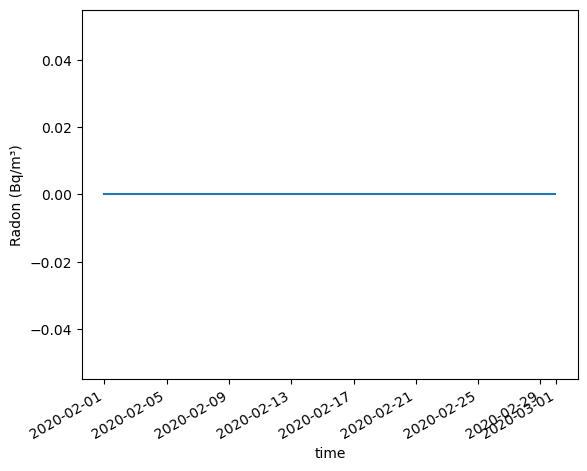

In [178]:
# Plot the result
(radon_model * 1e9).plot()
plt.ylabel("Radon (Bq/m³)")
plt.show()

TypeError: Invalid shape (696,) for image data

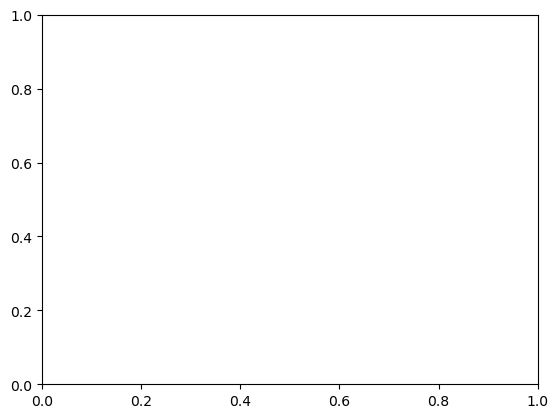

In [187]:
plt.imshow(radon_model.T, cmap="viridis", aspect="auto", extent=[rgl_202002.time.min(), rgl_202002.time.max(), rgl_202002.lat.min(), rgl_202002.lat.max()])
plt.colorbar(label="Radon (Bq/m³)")
plt.xlabel("Time")
plt.ylabel("Lat")
plt.title("Radon Model Heatmap")
plt.show()

In [186]:
print(radon_model.coords)

Coordinates:
  * time     (time) datetime64[ns] 2020-02-01 ... 2020-02-29T23:00:00


Text(0, 0.5, 'Radon (nmol/mol)')

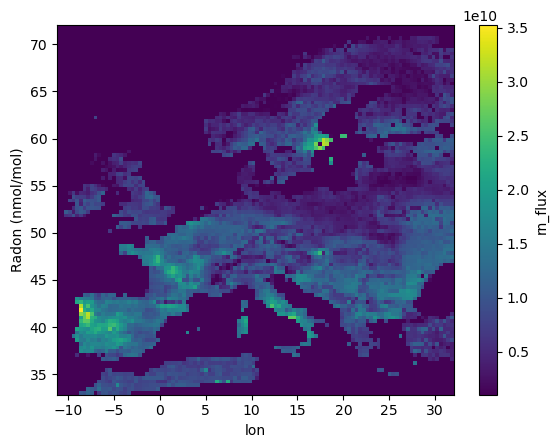

In [190]:
baseline_constant = 1.01  # Adjust this value based on your baseline estimation

# Calculate radon concentration by multiplying flux with time step and adding baseline
radon_concentration = (rn_flux_gldas_aligned["rn_flux"].sum(dim="time") + baseline_constant) * 1e9

# Plot the radon concentration
radon_concentration.plot()
plt.ylabel("Radon (nmol/mol)")

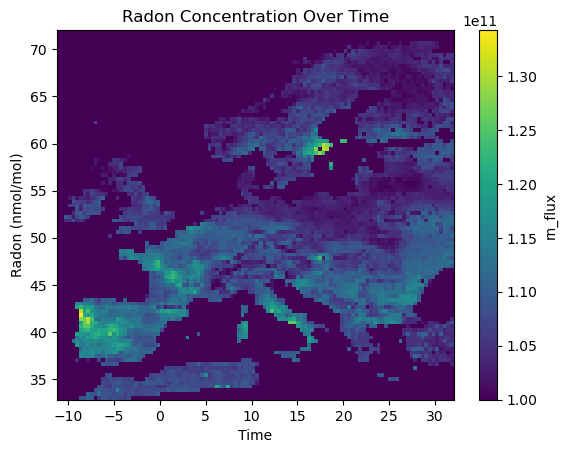